In [1]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import h5py
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import sys
sys.path.append('../')
import KMeans
%matplotlib inline
DIR_DATASET = "../data_set/"

In [2]:
filename = "N-CMAPSS_DS06.h5"

In [3]:
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

In [4]:
# Load data
with h5py.File(DIR_DATASET + filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))

W shape: (6779656, 4)
X_s shape: (6779656, 14)
X_v shape: (6779656, 14)
T shape: (6779656, 10)
A shape: (6779656, 4)


In [5]:
df_A = DataFrame(data=A, columns=A_var)
df_W = DataFrame(data=W, columns=W_var)
df_W['unit'] = df_A['unit'].values


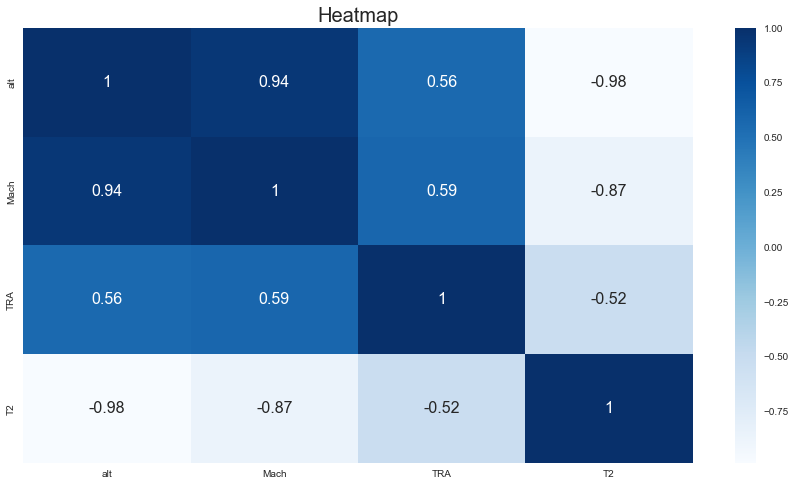

In [6]:
plt.figure(figsize=(15,8))
sns.heatmap(df_W.drop(["unit"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)

plt.show()

In [7]:
df_X_s = DataFrame(data=X_s, columns=X_s_var) 
df_X_s['unit'] = df_W['unit'].values
df_X_s['alt'] = df_W['alt'].values
df_X_s['Mach'] = df_W['Mach'].values
df_X_s['TRA'] = df_W['TRA'].values
df_X_s['T2'] = df_W['T2'].values
df_X_s['cycle'] = df_A['cycle'].values
df_X_s

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,cycle
0,628.041091,1511.541861,1927.043281,1306.041150,20.030745,14.445617,20.335782,25.648097,433.567253,440.308518,16.506580,2240.817096,8822.877846,5.280846,1.0,3002.0,0.370377,81.122467,521.900827,1.0
1,628.029107,1511.487263,1927.057002,1306.054316,20.028087,14.444604,20.333083,25.644403,433.481447,440.220073,16.502836,2240.682993,8822.661108,5.280108,1.0,3010.0,0.370818,81.122467,521.904702,1.0
2,628.036334,1511.476515,1927.009256,1305.986628,20.027190,14.444141,20.332173,25.643612,433.441995,440.180543,16.499506,2240.711266,8822.630498,5.279434,1.0,3017.0,0.371259,81.122467,521.912580,1.0
3,628.048399,1511.469365,1926.968895,1305.904807,20.025674,14.443352,20.330633,25.642218,433.385864,440.124037,16.494377,2240.760182,8822.608655,5.278578,1.0,3030.0,0.372078,81.122467,521.926210,1.0
4,628.051452,1511.428821,1926.871474,1305.799090,20.023900,14.442366,20.328833,25.640444,433.309866,440.047709,16.489573,2240.761587,8822.482371,5.277352,1.0,3038.0,0.372519,81.122467,521.930527,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6779651,565.800179,1277.058259,1502.594320,1142.177061,15.950583,13.629508,16.193486,18.220479,224.784836,229.525858,14.234065,1595.516423,8019.101012,2.159488,10.0,3031.0,0.234738,26.718559,513.457396,82.0
6779652,565.818559,1277.108574,1502.656699,1142.234454,15.953717,13.631977,16.196667,18.224022,224.836274,229.578329,14.237777,1595.545419,8019.268412,2.160036,10.0,3024.0,0.234486,26.718559,513.471020,82.0
6779653,565.839028,1277.158136,1502.728572,1142.299834,15.957096,13.634728,16.200097,18.227830,224.887760,229.630802,14.241483,1595.568340,8019.429669,2.160619,10.0,3017.0,0.234297,26.718559,513.487702,82.0
6779654,565.863014,1277.210866,1502.801785,1142.361098,15.960785,13.637842,16.203843,18.232013,224.941032,229.685135,14.245011,1595.596888,8019.600844,2.161217,10.0,3010.0,0.234234,26.718559,513.509052,82.0


In [8]:
#selezione unita e ciclo
unit=1
cycle=10

<Figure size 432x288 with 0 Axes>

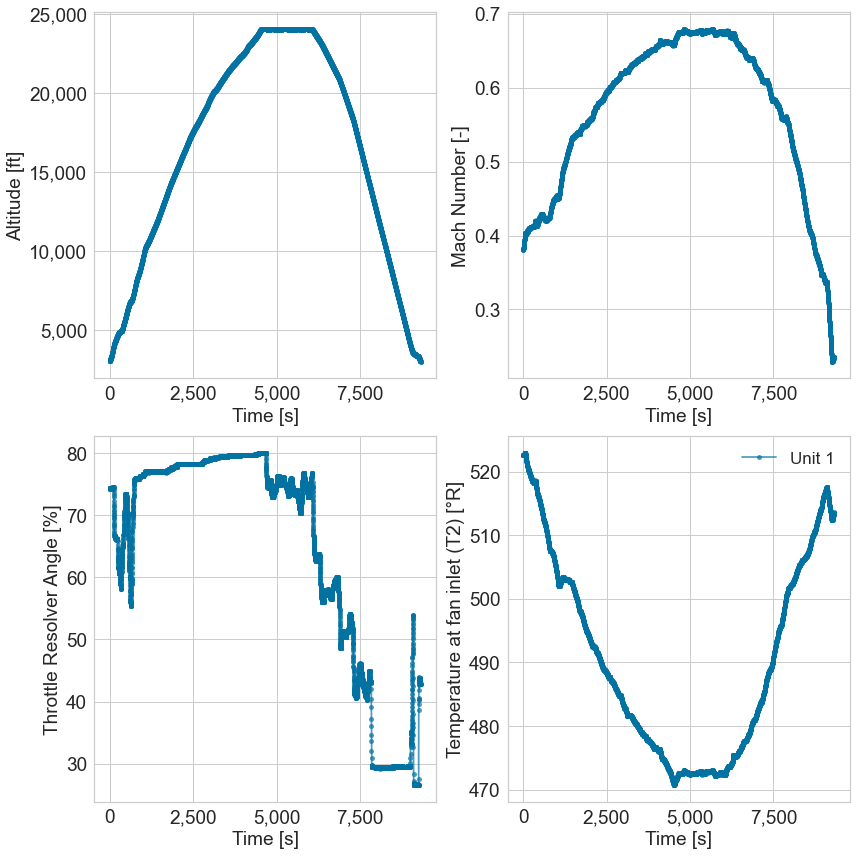

In [9]:
filter1 = df_X_s[df_X_s['unit']==unit]
filter1 = filter1[filter1['cycle']==cycle]
filter1.reset_index(inplace=True, drop=True)
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
plot_df_color_per_unit(filter1, W_var , labels, size=12, labelsize=19, name='./plot/flight_profile_'+ filename.replace('.h5','')+'_unit_'+str(unit)+'_cycle_'+str(cycle)+'.png')

In [10]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import root
x = np.array(np.arange(len(df_X_s)))
y = np.array(df_X_s['alt'].to_list())

# calcolare la derivata
dy_dx = np.gradient(y, x)

# trovare i punti stazionari
stationary_points = x[np.where(dy_dx == 0)[0]]

print(stationary_points)

df_X_s = df_X_s.iloc[stationary_points]
df_X_s.reset_index(inplace=True)

[   3013    3014    3017 ... 6777789 6777792 6777813]


<Figure size 432x288 with 0 Axes>

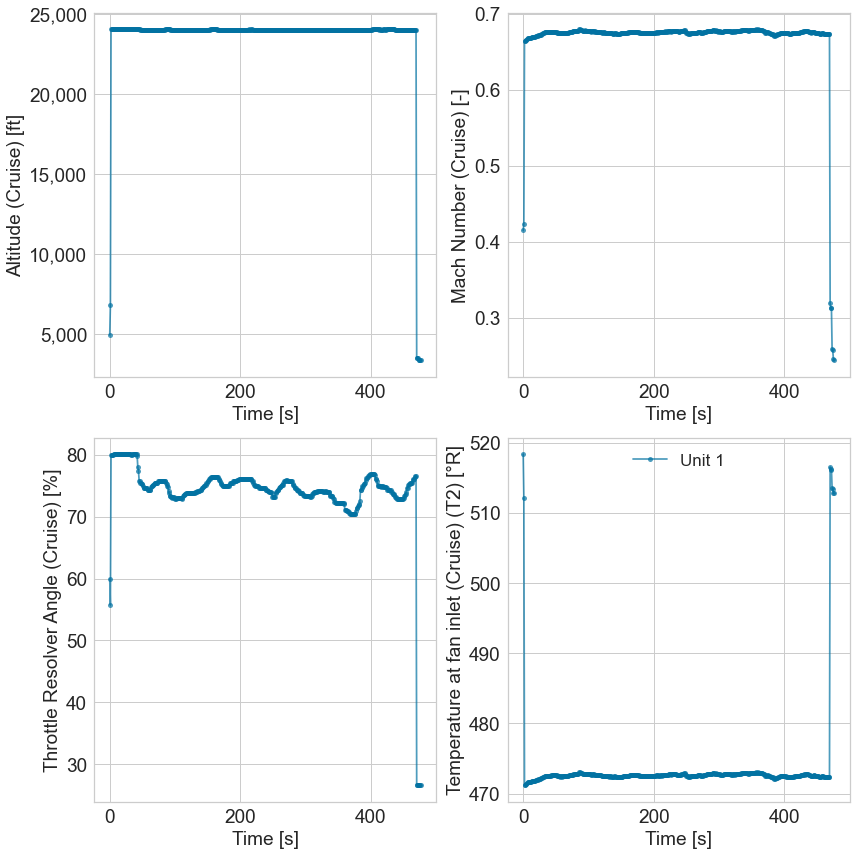

In [11]:
filter2 = df_X_s[df_X_s['unit']==unit]
filter2 = filter2[filter2['cycle']==cycle]
filter2.reset_index(inplace=True, drop=True)
labels = ['Altitude (Cruise) [ft]', 'Mach Number (Cruise) [-]', 'Throttle Resolver Angle (Cruise) [%]', 'Temperature at fan inlet (Cruise) (T2) [°R]']
plot_df_color_per_unit(filter2, W_var , labels, size=12, labelsize=19, name='./plot/flight_profile_'+ filename.replace('.h5','')+'_unit_'+str(unit)+'_cycle_'+str(cycle)+'_cruise_data.png')

## CLUSTERING

-3.7057890350468875e-15 1.0000000000000002
(839794, 19)


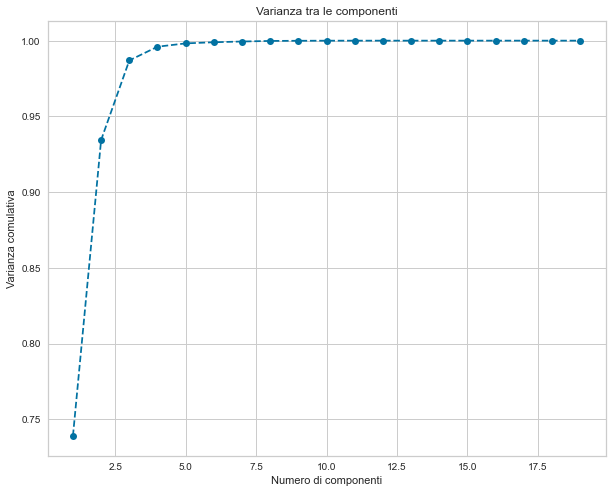

In [12]:
df_X_s_norm = KMeans.normalize_df(df_X_s.drop(columns=["unit",'cycle']))
KMeans.plot_variance_ratio(df_X_s_norm)

it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9
Numero di cluster (k-means): 2


KMeans(n_clusters=2, random_state=42)

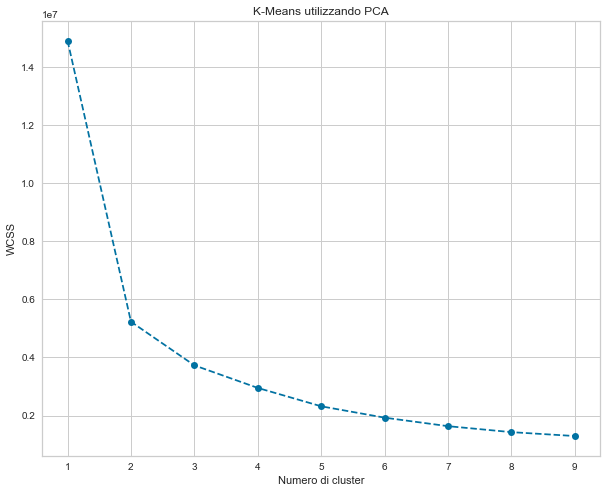

In [13]:
#prendiamo l'80% della varianza comulativa
scores_pca = KMeans.apply_pca(df_X_s_norm,2)
wcss = []
for i in range(1,10):
      kmeans_pca = KMeans.KMeans(n_clusters=i,init='k-means++',random_state=42)
      kmeans_pca.fit(scores_pca)
      wcss.append(kmeans_pca.inertia_)
      print("it",str(i))
plt.figure(figsize=(10,8))
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.title('K-Means utilizzando PCA')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
kl = KneeLocator(range(1,10),wcss,curve="convex",direction="decreasing")
print("Numero di cluster (k-means):",kl.elbow)
kmeans_pca = KMeans.KMeans(n_clusters=kl.elbow,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

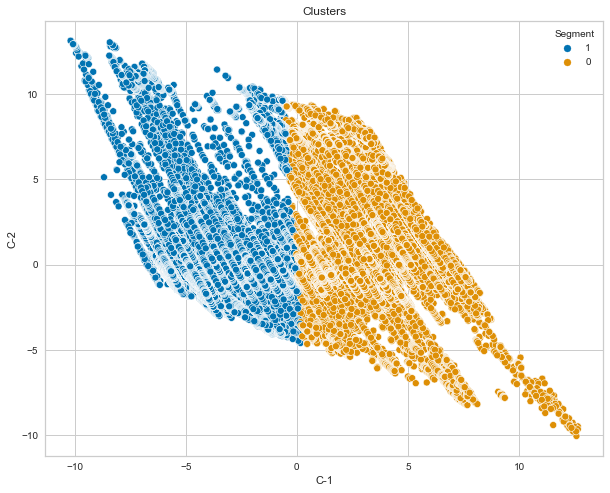

,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,unit,alt,Mach,TRA,T2,cycle,C-1,C-2,Segm K-means PCA,Segment
0,3013,567.862625,1359.511525,1707.084365,1126.677587,10.800029,7.907752,10.964496,13.874934,223.895745,...,1.0,22984.0,0.652869,79.452560,473.933456,1.0,-1.151792,-2.834855,1,1
1,3014,567.588475,1358.166111,1703.733953,1124.722523,10.788917,7.907769,10.953215,13.853403,223.112494,...,1.0,22984.0,0.652869,79.100998,473.933744,1.0,-1.201792,-2.734684,1,1
2,3017,566.640494,1353.941856,1696.060715,1120.994975,10.753025,7.912485,10.916776,13.779816,220.756055,...,1.0,22985.0,0.653625,77.958427,474.016431,1.0,-1.332744,-2.449098,1,1
3,3020,566.016639,1351.410258,1691.258650,1118.665285,10.729145,7.913807,10.892532,13.731582,219.342750,...,1.0,22987.0,0.653940,77.255310,474.042937,1.0,-1.413563,-2.274351,1,1
4,3021,565.759111,1350.647674,1690.559426,1118.545916,10.717307,7.910579,10.880515,13.711224,218.927402,...,1.0,22987.0,0.653436,77.079529,473.987688,1.0,-1.435044,-2.230889,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839789,6777782,576.262096,1359.216318,1677.213165,1160.927482,13.657241,10.694469,13.865219,16.809241,247.543329,...,10.0,13259.0,0.523215,57.655838,497.194557,82.0,2.239319,-0.590551,0,0
839790,6777787,576.057214,1358.392658,1675.422653,1160.006550,13.645833,10.691115,13.853638,16.790008,247.018424,...,10.0,13258.0,0.522711,57.480061,497.148073,82.0,2.208028,-0.532606,0,0
839791,6777789,575.959454,1358.263810,1675.558549,1160.221057,13.638872,10.685546,13.846570,16.780443,246.937030,...,10.0,13257.0,0.521892,57.480061,497.072222,82.0,2.203695,-0.528483,0,0
839792,6777792,575.853076,1358.131940,1675.543001,1160.307841,13.631210,10.678941,13.838792,16.770187,246.849128,...,10.0,13255.0,0.520884,57.480061,496.980640,82.0,2.197599,-0.522424,0,0


In [15]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)
KMeans.view_kmeans_results_2d(df_segm_pca_kmeans,scores_pca,kmeans_pca)

In [16]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)

KMeans.calculate_centroids(df_segm_pca_kmeans,scores_pca,"",0)

-3.911699658502482e-16 1.0
(423715, 21)
-3.862536795426535e-15 1.0000000000000007
(416079, 21)


,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,cycle,group
mean,3.575965e+06,580.213383,1351.954350,1651.037592,1153.372371,14.825361,11.705696,15.051128,18.061951,264.695517,...,1935.236630,8310.067002,2.807491,5.529143,10157.310043,0.463268,54.387509,503.831776,42.192507,0.0
mean,3.225396e+06,551.712318,1313.321493,1635.548685,1087.543768,9.631827,7.240828,9.778504,12.185972,189.520520,...,2036.353975,8186.023654,2.037489,5.015129,25452.853369,0.666016,72.249431,465.979113,37.104459,1.0


Text(0, 0.5, 'Flight Class # [-]')

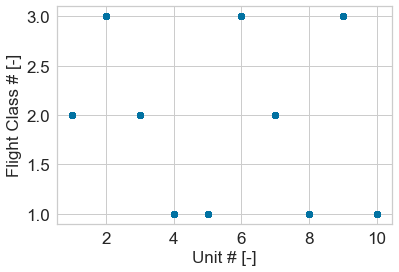

In [17]:
labelsize = 17
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

In [18]:
dic = {}
for i in range(1,len(set(df_A.unit))+1):
    dic[i] = int(df_A[df_A.unit==i]["Fc"].iloc[0])
dic

{1: 2, 2: 3, 3: 2, 4: 1, 5: 1, 6: 3, 7: 2, 8: 1, 9: 3, 10: 1}

In [19]:
df_segm_pca_kmeans['class'] = df_segm_pca_kmeans['unit'].map(dic)
df_segm_pca_kmeans

,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,alt,Mach,TRA,T2,cycle,C-1,C-2,Segm K-means PCA,Segment,class
0,3013,567.862625,1359.511525,1707.084365,1126.677587,10.800029,7.907752,10.964496,13.874934,223.895745,...,22984.0,0.652869,79.452560,473.933456,1.0,-1.151792,-2.834855,1,1,2
1,3014,567.588475,1358.166111,1703.733953,1124.722523,10.788917,7.907769,10.953215,13.853403,223.112494,...,22984.0,0.652869,79.100998,473.933744,1.0,-1.201792,-2.734684,1,1,2
2,3017,566.640494,1353.941856,1696.060715,1120.994975,10.753025,7.912485,10.916776,13.779816,220.756055,...,22985.0,0.653625,77.958427,474.016431,1.0,-1.332744,-2.449098,1,1,2
3,3020,566.016639,1351.410258,1691.258650,1118.665285,10.729145,7.913807,10.892532,13.731582,219.342750,...,22987.0,0.653940,77.255310,474.042937,1.0,-1.413563,-2.274351,1,1,2
4,3021,565.759111,1350.647674,1690.559426,1118.545916,10.717307,7.910579,10.880515,13.711224,218.927402,...,22987.0,0.653436,77.079529,473.987688,1.0,-1.435044,-2.230889,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839789,6777782,576.262096,1359.216318,1677.213165,1160.927482,13.657241,10.694469,13.865219,16.809241,247.543329,...,13259.0,0.523215,57.655838,497.194557,82.0,2.239319,-0.590551,0,0,1
839790,6777787,576.057214,1358.392658,1675.422653,1160.006550,13.645833,10.691115,13.853638,16.790008,247.018424,...,13258.0,0.522711,57.480061,497.148073,82.0,2.208028,-0.532606,0,0,1
839791,6777789,575.959454,1358.263810,1675.558549,1160.221057,13.638872,10.685546,13.846570,16.780443,246.937030,...,13257.0,0.521892,57.480061,497.072222,82.0,2.203695,-0.528483,0,0,1
839792,6777792,575.853076,1358.131940,1675.543001,1160.307841,13.631210,10.678941,13.838792,16.770187,246.849128,...,13255.0,0.520884,57.480061,496.980640,82.0,2.197599,-0.522424,0,0,1


In [20]:
for i in range(0,3):
    filtered = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"]==i]
    contatori = filtered['class'].value_counts()
    df_contatori = pd.DataFrame({'Classe': contatori.index, 'Conteggio': contatori.values})
    print("cluster",i)
    print(df_contatori)
    print("totale cluster",i,":",df_contatori["Conteggio"].sum())


cluster 0
   Classe  Conteggio
0       1     190231
1       3     125098
2       2     108386
totale cluster 0 : 423715
cluster 1
   Classe  Conteggio
0       3     294638
1       2     119806
2       1       1635
totale cluster 1 : 416079
cluster 2
Empty DataFrame
Columns: [Classe, Conteggio]
Index: []
totale cluster 2 : 0


In [21]:
df_segm_pca_kmeans_f = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"] == 1]
df_W_u = df_segm_pca_kmeans_f[df_segm_pca_kmeans_f.unit == 8]
df_W_u.reset_index(inplace=True, drop=True)
df_W_u
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
#plot_df_color_per_unit(df_W_u, W_var , labels, size=12, labelsize=19, name='flight_profile_DS02_clustering.png')
print('min:',df_W_u['alt'].min())
print('max:',df_W_u['alt'].max())

min: 8744.0
max: 17762.0
